In [1]:
DF_PATH = r"../data/raw/explored_df.pkl"
EXPORT_PATH = r"../data/processed"
RAW_PATH = r"../data/raw"

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import joblib

## imbalance
from imblearn.over_sampling import SMOTE

## skelarn -- preprocessing
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn_features.transformers import DataFrameSelector
from sklearn.base import BaseEstimator, TransformerMixin

## skelarn -- models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

## sklearn -- metrics
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, RocCurveDisplay, roc_auc_score

## sklearn -- tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, cross_val_score

In [ ]:
# load data with pickle
def load_data(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

X_train = load_data(os.path.join(RAW_PATH, 'X_train_total.pkl'))
y_train = load_data(os.path.join(RAW_PATH, 'y_train_total.pkl'))
X_test  = load_data(os.path.join(EXPORT_PATH, 'X_test.pkl'))
y_test  = load_data(os.path.join(EXPORT_PATH, 'y_test.pkl'))
print('Train set unprocessed:', X_train.shape, y_train.shape)
print('Test set unprocessed :', X_test.shape, y_test.shape)

Train set unprocessed: (5271, 18) (5271,)
Test set unprocessed : (1318, 18) (1318,)


In [ ]:
X_train.columns

Index(['age', 'married', 'number_of_dependents', 'number_of_referrals',
       'tenure_in_months', 'offer', 'phone_service',
       'avg_monthly_long_distance_charges', 'multiple_lines',
       'internet_service', 'internet_type', 'avg_monthly_gb_download',
       'unlimited_data', 'contract', 'paperless_billing', 'payment_method',
       'total_revenue', 'enrolled_services'],
      dtype='object')

In [ ]:
X_train.head()

,age,married,number_of_dependents,number_of_referrals,tenure_in_months,offer,phone_service,avg_monthly_long_distance_charges,multiple_lines,internet_service,internet_type,avg_monthly_gb_download,unlimited_data,contract,paperless_billing,payment_method,total_revenue,enrolled_services
3836,57,Yes,0,7,50,Offer B,Yes,20.79,Yes,Yes,Fiber Optic,7.0,Yes,One Year,Yes,Mailed Check,6272.40,5
2673,42,Yes,0,1,39,NaN,Yes,35.70,No,Yes,DSL,9.0,Yes,One Year,No,Credit Card,4575.25,6
4927,78,No,0,0,64,Offer B,Yes,19.20,Yes,Yes,Fiber Optic,18.0,Yes,Month-to-Month,Yes,Bank Withdrawal,7777.45,5
5176,53,No,0,0,45,NaN,No,NaN,No,Yes,DSL,10.0,Yes,One Year,No,Bank Withdrawal,1840.75,3
1142,31,Yes,0,3,51,Offer B,Yes,29.40,Yes,Yes,Fiber Optic,21.0,No,One Year,Yes,Bank Withdrawal,7138.20,5


### Create pipeline to transform data

In [ ]:
num_cols = ['age', 'number_of_dependents', 'number_of_referrals', 'tenure_in_months', 'avg_monthly_long_distance_charges',
            'avg_monthly_gb_download', 'total_revenue', 'enrolled_services']
           

bin_cols = ['married', 'phone_service', 'multiple_lines', 'internet_service', 'unlimited_data', 'paperless_billing']
cat_cols = ['offer', 'payment_method']

ord_cols_1 = ['internet_type']
ord_cols_2 = ['contract']

In [ ]:
## create a custom column selector
class ColumnSelector(BaseEstimator, TransformerMixin):
    """select specific columns of a given dataset"""
    def __init__(self, subset):
        self.subset = subset
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.loc[:, self.subset]
    
    def fit_transform(self, X, y=None):
        return X[self.subset]

In [ ]:
## Pipeline

## Numerical: num_cols --> Imputing using median, and standardscaler
## Categorical: cat_cols ---> Imputing using mode, and OHE
## Ordinal: ord_cols_1, ord_cols_2 ---> Imputing using mode, and ordinalEncoder

## For Numerical
num_pipeline = Pipeline(steps=[
                        ('selector', ColumnSelector(num_cols)),
                        ('imputer', SimpleImputer(strategy='median')),
                        ('scaler', MinMaxScaler())
                    ])  


## For Categorical
cat_pipeline = Pipeline(steps=[
                        ('selector', ColumnSelector(cat_cols)),
                        ('imputer', SimpleImputer(strategy='most_frequent')),
                        ('ohe', OneHotEncoder(sparse_output=False))
                    ])

## For Binary columns
bin_pipeline = Pipeline(steps=[
                        ('selector', ColumnSelector(bin_cols)),
                        ('imputer', SimpleImputer(strategy='most_frequent')),
                        ('ohe', OneHotEncoder(drop='first', sparse_output=False))
                    ])

## For ord_cols_1
ordinal_pipeline_1 = Pipeline(steps=[
                        ('selector', ColumnSelector(ord_cols_1)),
                        ('imputer', SimpleImputer(strategy='most_frequent')),
                        ('encoder',OrdinalEncoder(categories=[['No', 'Cable', 'DSL', 'Fiber Optic']]))
                    ])


## For ord_cols_1
ordinal_pipeline_2 = Pipeline(steps=[
                        ('selector', ColumnSelector(ord_cols_2)),
                        ('imputer', SimpleImputer(strategy='most_frequent')),
                        ('encoder',OrdinalEncoder(categories=[['Month-to-Month', 'One Year', 'Two Year']]))
                    ])


## combine all
all_pipeline = FeatureUnion(transformer_list=[
                                    ('numerical', num_pipeline),
                                    ('categorical', cat_pipeline),
                                    ('binary', bin_pipeline),
                                    ('ord_1', ordinal_pipeline_1),
                                    ('ord_2', ordinal_pipeline_2)
                                ])

## apply
all_pipeline.fit(X_train)
X_train_final = all_pipeline.transform(X_train)
X_test_final = all_pipeline.transform(X_test)

In [ ]:
joblib.dump(all_pipeline, '../models/pipeline.pkl')

['../models/pipeline.pkl']

In [ ]:
all_pipeline

FeatureUnion(transformer_list=[('numerical',
                                Pipeline(steps=[('selector',
                                                 ColumnSelector(subset=['age',
                                                                        'number_of_dependents',
                                                                        'number_of_referrals',
                                                                        'tenure_in_months',
                                                                        'avg_monthly_long_distance_charges',
                                                                        'avg_monthly_gb_download',
                                                                        'total_revenue',
                                                                        'enrolled_services'])),
                                                ('imputer',
                                                 SimpleImputer(strategy='median')),
                                                ('scaler', MinMaxScaler())])),
                               ('categori...
                                                 ColumnSelector(subset=['internet_type'])),
                                                ('imputer',
                                                 SimpleImputer(strategy='most_frequent')),
                                                ('encoder',
                                                 OrdinalEncoder(categories=[['No',
                                                                             'Cable',
                                                                             'DSL',
                                                                             'Fiber '
                                                                             'Optic']]))])),
                               ('ord_2',
                                Pipeline(steps=[('selector',
                                                 ColumnSelector(subset=['contract'])),
                                                ('imputer',
                                                 SimpleImputer(strategy='most_frequent')),
                                                ('encoder',
                                                 OrdinalEncoder(categories=[['Month-to-Month',
                                                                             'One '
                                                                             'Year',
                                                                             'Two '
                                                                             'Year']]))]))])

In [ ]:
all_pipeline.named_transformers

{'numerical': Pipeline(steps=[('selector',
                  ColumnSelector(subset=['age', 'number_of_dependents',
                                         'number_of_referrals',
                                         'tenure_in_months',
                                         'avg_monthly_long_distance_charges',
                                         'avg_monthly_gb_download',
                                         'total_revenue',
                                         'enrolled_services'])),
                 ('imputer', SimpleImputer(strategy='median')),
                 ('scaler', MinMaxScaler())]),
 'categorical': Pipeline(steps=[('selector',
                  ColumnSelector(subset=['offer', 'payment_method'])),
                 ('imputer', SimpleImputer(strategy='most_frequent')),
                 ('ohe', OneHotEncoder(sparse_output=False))]),
 'binary': Pipeline(steps=[('selector',
                  ColumnSelector(subset=['married', 'phone_service',
                    

In [ ]:
all_pipeline.named_transformers['categorical'].named_steps['ohe'].get_feature_names_out(cat_cols)

array(['offer_Offer A', 'offer_Offer B', 'offer_Offer C', 'offer_Offer D',
       'offer_Offer E', 'payment_method_Bank Withdrawal',
       'payment_method_Credit Card', 'payment_method_Mailed Check'],
      dtype=object)

In [ ]:
print(X_train_final.shape)
print(X_test_final.shape)

(5271, 24)
(1318, 24)


In [ ]:
ohe_cat_names = list(all_pipeline.named_transformers['categorical'].named_steps['ohe'].get_feature_names_out(cat_cols))
ohe_cat_names

['offer_Offer A',
 'offer_Offer B',
 'offer_Offer C',
 'offer_Offer D',
 'offer_Offer E',
 'payment_method_Bank Withdrawal',
 'payment_method_Credit Card',
 'payment_method_Mailed Check']

In [ ]:
ohe_bin_names = list(all_pipeline.named_transformers['binary'].named_steps['ohe'].get_feature_names_out(bin_cols))
ohe_bin_names

['married_Yes',
 'phone_service_Yes',
 'multiple_lines_Yes',
 'internet_service_Yes',
 'unlimited_data_Yes',
 'paperless_billing_Yes']

In [ ]:
X_train.columns

Index(['age', 'married', 'number_of_dependents', 'number_of_referrals',
       'tenure_in_months', 'offer', 'phone_service',
       'avg_monthly_long_distance_charges', 'multiple_lines',
       'internet_service', 'internet_type', 'avg_monthly_gb_download',
       'unlimited_data', 'contract', 'paperless_billing', 'payment_method',
       'total_revenue', 'enrolled_services'],
      dtype='object')

In [ ]:
all_cols = ['age', 'married_Yes', 'number_of_dependents', 'number_of_referrals',
            'tenure_in_months', 'offer_Offer A', 'offer_Offer B', 'offer_Offer C',
            'offer_Offer D', 'offer_Offer E', 'phone_service_Yes','avg_monthly_long_distance_charges',
            'multiple_lines_Yes', 'internet_service_Yes', 'internet_type', 'avg_monthly_gb_download',
            'unlimited_data_Yes', 'contract', 'paperless_billing_Yes', 'payment_method_Bank Withdrawal',
            'payment_method_Credit Card', 'payment_method_Mailed Check', 'total_revenue', 'enrolled_services']
all_cols

['age',
 'married_Yes',
 'number_of_dependents',
 'number_of_referrals',
 'tenure_in_months',
 'offer_Offer A',
 'offer_Offer B',
 'offer_Offer C',
 'offer_Offer D',
 'offer_Offer E',
 'phone_service_Yes',
 'avg_monthly_long_distance_charges',
 'multiple_lines_Yes',
 'internet_service_Yes',
 'internet_type',
 'avg_monthly_gb_download',
 'unlimited_data_Yes',
 'contract',
 'paperless_billing_Yes',
 'payment_method_Bank Withdrawal',
 'payment_method_Credit Card',
 'payment_method_Mailed Check',
 'total_revenue',
 'enrolled_services']

In [ ]:
X_train_final

array([[0.62295082, 0.        , 0.63636364, ..., 1.        , 3.        ,
        1.        ],
       [0.37704918, 0.        , 0.09090909, ..., 0.        , 2.        ,
        1.        ],
       [0.96721311, 0.        , 0.        , ..., 1.        , 3.        ,
        0.        ],
       ...,
       [0.62295082, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.44262295, 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.52459016, 0.        , 0.        , ..., 1.        , 3.        ,
        0.        ]])

### Solving class imbalance using SMOTE for over sampling

In [ ]:
# transform target
le = LabelEncoder()
y_train_final = le.fit_transform(y_train)
y_test_final = le.transform(y_test)

In [ ]:
print(y_train_final[:5])
print(y_test_final[:5])

[1 0 1 1 1]
[1 0 1 1 1]


In [ ]:
over = SMOTE(sampling_strategy=0.8, random_state=42)
X_train_resampled, y_train_resampled = over.fit_resample(X_train_final, y_train_final)

In [ ]:
print(X_train_resampled.shape)
print(y_train_resampled.shape)

(6796, 24)
(6796,)


### Training RandomForest on total training data

RandomForestClassifier(max_features=15, max_leaf_nodes=24, n_estimators=75)
Results on Test data
Test accuracy =  0.8695
Test precision =  0.9223
Test recall =  0.8930
Classification report:
              precision    recall  f1-score   support

           0       0.75      0.81      0.78       374
           1       0.92      0.89      0.91       944

    accuracy                           0.87      1318
   macro avg       0.84      0.85      0.84      1318
weighted avg       0.87      0.87      0.87      1318

Confusion matrix (Rows actual, Columns predicted):
     0    1
0  303   71
1  101  843

ROC curve


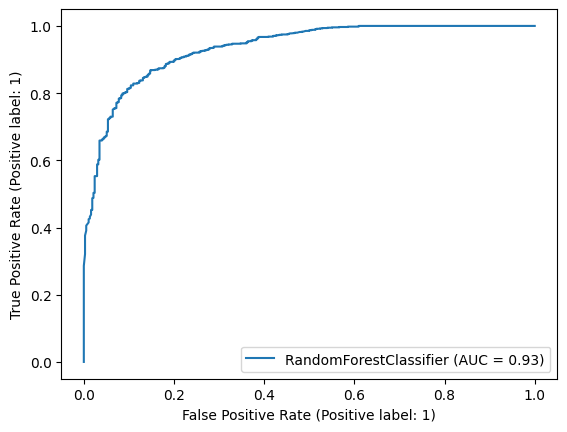

In [ ]:
# Best Hyperparameters from last notebook
max_features = 15
max_leaf_nodes = 24 
n_estimators = 75

# Train and test model
good_model_rf = RandomForestClassifier(max_leaf_nodes = max_leaf_nodes,
                                    max_features = max_features, 
                                    n_estimators=n_estimators) 

print(good_model_rf) # display model parameters
good_model_rf.fit(X_train_resampled, y_train_resampled) # train model
pred_rf = good_model_rf.predict(X_test_final) 

print("Results on Test data")
acc_rf = accuracy_score(y_test_final, pred_rf) 
prec_rf = precision_score(y_test_final, pred_rf) 
reca_rf = recall_score(y_test_final, pred_rf) 

print(f'Test accuracy = {acc_rf: .4f}') 
print(f'Test precision = {prec_rf: .4f}')
print(f'Test recall = {reca_rf: .4f}') 
print("Classification report:")
print(classification_report(y_test_final, pred_rf))
print("Confusion matrix (Rows actual, Columns predicted):")
print(pd.DataFrame(confusion_matrix(y_test_final, pred_rf)))

print('\nROC curve')
RocCurveDisplay.from_estimator(good_model_rf, X_test_final, y_test_final)
plt.show()

### Training XGBoost on total training data

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.5, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)
Results on Test data
Test accuracy =  0.8672
Test precision =  0.9069
Test recall =  0.9078
Classification report:
              precision    recall  f1-score   support

           0       0.77      0.76      0.77       374
           1       0.91 

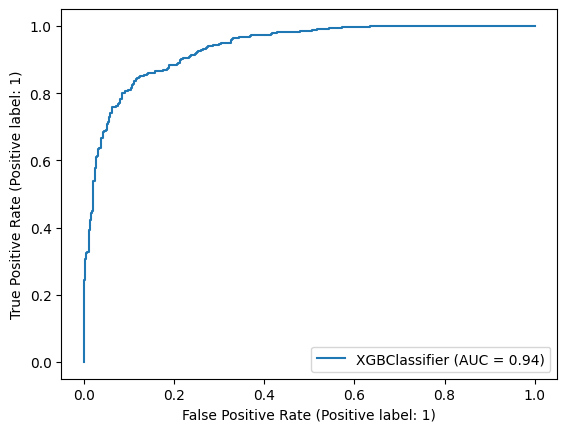

In [ ]:
# Best Hyperparameters from last notebook
booster = 'gbtree'
gamma = 0.5
learning_rate = 0.1
n_estimators = 200
reg_alpha = 0.5
reg_lambda = 1

# Train and test model
good_model_xgb = XGBClassifier(booster = 'gbtree',
                              gamma = 0.5,
                              learning_rate = 0.1,
                              n_estimators = 200,
                              reg_alpha = 0.5,
                              reg_lambda = 1, random_state=42) 

print(good_model_xgb) # display model parameters
good_model_xgb.fit(X_train_resampled, y_train_resampled) # train model
pred_xgb = good_model_xgb.predict(X_test_final) 

print("Results on Test data")
acc_xgb = accuracy_score(y_test_final, pred_xgb) 
prec_xgb = precision_score(y_test_final, pred_xgb) 
reca_xgb = recall_score(y_test_final, pred_xgb) 

print(f'Test accuracy = {acc_xgb: .4f}') 
print(f'Test precision = {prec_xgb: .4f}')
print(f'Test recall = {reca_xgb: .4f}') 
print("Classification report:")
print(classification_report(y_test_final, pred_xgb))
print("Confusion matrix (Rows actual, Columns predicted):")
print(pd.DataFrame(confusion_matrix(y_test_final, pred_xgb)))

print('\nROC curve')
RocCurveDisplay.from_estimator(good_model_xgb, X_test_final, y_test_final)
plt.show()

### XGBoost wins 
- I will save both models anyways

In [ ]:
models_opt = []

models_opt.append(('XGBoost', XGBClassifier(booster = 'gbtree', gamma = 0.5, learning_rate = 0.1, n_estimators = 200,
                              reg_alpha = 0.5, reg_lambda = 1, random_state=42)))
models_opt.append(('Random Forest', RandomForestClassifier(max_leaf_nodes=15, max_features=24, n_estimators=75, criterion='gini', random_state=42)))

In [ ]:
acc_results_opt =[]
auc_results_opt =[]
pre_results_opt =[]
f1_results_opt =[]
names_opt = []

result_col_opt = ["Algorithm", "ROC AUC", "Accuracy", 'Precision', 'F1 Scores']
model_results_opt = pd.DataFrame(columns = result_col_opt)

i=0
# K- fold cross validation

for name, model in models_opt:
    names_opt.append(name)
    
    cv_acc_results_opt = cross_val_score(model, X_train_resampled, y_train_resampled, scoring="accuracy")
    cv_auc_results_opt = cross_val_score(model, X_train_resampled, y_train_resampled, scoring="roc_auc")
    cv_pre_results_opt = cross_val_score(model, X_train_resampled, y_train_resampled, scoring="precision")
    cv_f1_results_opt = cross_val_score(model, X_train_resampled, y_train_resampled, scoring="f1")

    acc_results_opt.append(cv_acc_results_opt)
    auc_results_opt.append(cv_auc_results_opt)
    pre_results_opt.append(cv_pre_results_opt)
    f1_results_opt.append(cv_f1_results_opt)
    
    model_results_opt.loc[i] = [name, 
                           round(cv_auc_results_opt.mean()*100,2),
                           round(cv_acc_results_opt.mean()*100,2),
                           round(cv_pre_results_opt.mean()*100,2),
                           round(cv_f1_results_opt.mean()*100,2)]
    i+=1

model_results_opt.sort_values(by = ['ROC AUC'], ascending=False)

,Algorithm,ROC AUC,Accuracy,Precision,F1 Scores
0,XGBoost,95.98,88.57,89.66,89.93
1,Random Forest,93.22,85.29,86.00,86.92


In [ ]:
# precision_score  recall_score

acc_results_opt_val =[]
auc_results_opt_val =[]
pre_results_opt_val =[]
f1_results_opt_val =[]
rec_results_opt_val =[]
names_opt_val = []
good_models_names = [('RandomForest', pred_rf), ('XGBoost', pred_xgb)]

result_col_opt = ["Algorithm", "ROC AUC", "Accuracy", 'Precision', 'Recall', 'F1 Scores']
model_results_opt_val = pd.DataFrame(columns = result_col_opt)

i=0
# K- fold cross validation

for name, y_pred in good_models_names:
    names_opt_val.append(name)
    
    cv_acc_results_opt = accuracy_score(y_test_final, y_pred)
    cv_auc_results_opt = roc_auc_score(y_test_final, y_pred)
    cv_pre_results_opt = precision_score(y_test_final, y_pred)
    cv_f1_results_opt = f1_score(y_test_final, y_pred)
    cv_rec_results_opt = recall_score(y_test_final, y_pred)

    acc_results_opt_val.append(cv_acc_results_opt)
    auc_results_opt_val.append(cv_auc_results_opt)
    pre_results_opt_val.append(cv_pre_results_opt)
    f1_results_opt_val.append(cv_f1_results_opt)
    rec_results_opt_val.append(cv_rec_results_opt)

    model_results_opt_val.loc[i] = [name, 
                           round(cv_auc_results_opt.mean()*100,2),
                           round(cv_acc_results_opt.mean()*100,2),
                           round(cv_pre_results_opt.mean()*100,2),
                           round(cv_rec_results_opt.mean()*100,2),
                           round(cv_f1_results_opt.mean()*100,2)]
    i+=1

model_results_opt_val.sort_values(by = ['ROC AUC'], ascending=False)

,Algorithm,ROC AUC,Accuracy,Precision,Recall,F1 Scores
0,RandomForest,85.16,86.95,92.23,89.30,90.74
1,XGBoost,83.63,86.72,90.69,90.78,90.74


#### Getting feature importance

In [ ]:
# For RandomForest model
features = all_cols
importance_rf = good_model_rf.feature_importances_
feat_imp_rf = pd.Series(data=importance_rf, index=features)
feat_imp_rf

age                                  0.029870
married_Yes                          0.043196
number_of_dependents                 0.138524
number_of_referrals                  0.174763
tenure_in_months                     0.001856
offer_Offer A                        0.004144
offer_Offer B                        0.030875
offer_Offer C                        0.017891
offer_Offer D                        0.000000
offer_Offer E                        0.000000
phone_service_Yes                    0.000087
avg_monthly_long_distance_charges    0.000194
multiple_lines_Yes                   0.000083
internet_service_Yes                 0.000142
internet_type                        0.002011
avg_monthly_gb_download              0.000000
unlimited_data_Yes                   0.006058
contract                             0.000486
paperless_billing_Yes                0.000836
payment_method_Bank Withdrawal       0.003346
payment_method_Credit Card           0.000058
payment_method_Mailed Check       

In [ ]:
# For XGBoost model
features = all_cols
importance_xgb = good_model_xgb.feature_importances_
feat_imp_xgb = pd.Series(data=importance_xgb, index=features)
feat_imp_xgb

age                                  0.017014
married_Yes                          0.063752
number_of_dependents                 0.072309
number_of_referrals                  0.055501
tenure_in_months                     0.010632
offer_Offer A                        0.010178
offer_Offer B                        0.011385
offer_Offer C                        0.032449
offer_Offer D                        0.007369
offer_Offer E                        0.009253
phone_service_Yes                    0.007625
avg_monthly_long_distance_charges    0.012724
multiple_lines_Yes                   0.011578
internet_service_Yes                 0.009891
internet_type                        0.030608
avg_monthly_gb_download              0.007006
unlimited_data_Yes                   0.011094
contract                             0.014363
paperless_billing_Yes                0.020735
payment_method_Bank Withdrawal       0.026800
payment_method_Credit Card           0.011082
payment_method_Mailed Check       

In [ ]:
feat_imp_df = pd.DataFrame({'RandomForest': feat_imp_rf, 'XGBClassifier': feat_imp_xgb}, index=features)
feat_imp_df.sort_values(by='RandomForest', ascending=False)

,RandomForest,XGBClassifier
enrolled_services,0.475862,0.458570
number_of_referrals,0.174763,0.055501
number_of_dependents,0.138524,0.072309
total_revenue,0.067786,0.059356
married_Yes,0.043196,0.063752
offer_Offer B,0.030875,0.011385
age,0.029870,0.017014
offer_Offer C,0.017891,0.032449
unlimited_data_Yes,0.006058,0.011094
offer_Offer A,0.004144,0.010178


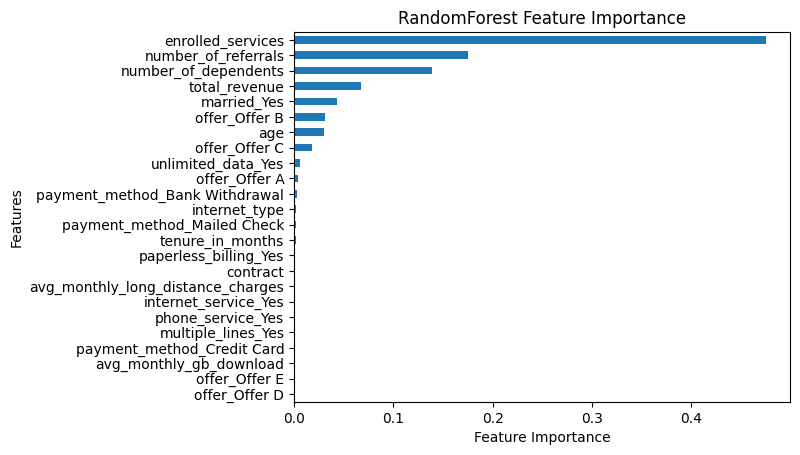

In [ ]:
feat_imp_rf.sort_values().plot(kind='barh')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title('RandomForest Feature Importance')
plt.show()

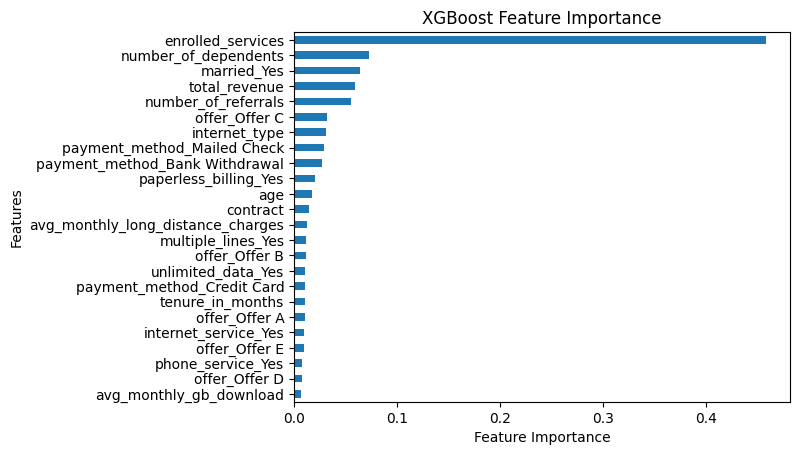

In [ ]:
feat_imp_xgb.sort_values().plot(kind='barh')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title('XGBoost Feature Importance')
plt.show()

### Saving models

In [ ]:
# save random forest
joblib.dump(good_model_rf, '../models/forest_tuned.pkl')

# save xgboost
joblib.dump(good_model_xgb, '../models/XGBoost_tuned.pkl')


['../models/XGBoost_tuned.pkl']